In [1]:
import pandas as pd
import networkx as nx
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# Load the dataset
data = pd.read_csv("../Datasets/Marketing campaign dataset.csv")

# Select relevant features
selected_columns = [
    'campaign_item_id', 'advertiser_id', 'advertiser_name', 'ext_service_id', 'ext_service_name',
    'creative_id', 'creative_width', 'creative_height', 'search_tags', 'template_id','channel_id', 'channel_name', 'campaign_budget_usd', 
    'media_cost_usd', 'impressions', 'clicks', 'time', 'weekday_cat','landing_page', 'network_id',
]

data = data[selected_columns]

# Convert time to datetime for later use
data['time'] = pd.to_datetime(data['time'])

# Encode categorical features
le = LabelEncoder()
categorical_cols = ['campaign_item_id', 'advertiser_id', 'ext_service_name', 'channel_name', 'weekday_cat', 'search_tags']
for col in categorical_cols:
    data[col] = le.fit_transform(data[col])

# Display the processed data
print(data.head())

   campaign_item_id  advertiser_id  ext_service_name  creative_id  \
0                 0              0                 1         1000   
1                 0              0                 0         1000   
2                 0              0                 1         1000   
3                 0              0                 1         1000   
4                 0              0                 2         1000   

   creative_width  creative_height  search_tags  template_id  channel_name  \
0           300.0            250.0            2         90.0             1   
1           300.0            250.0            0         90.0             3   
2           300.0            250.0            1         90.0             3   
3           300.0            250.0            0         90.0             4   
4           300.0            250.0            0         90.0             1   

   campaign_budget_usd  media_cost_usd  impressions  clicks       time  \
0           652.173913       14.058514    

In [10]:
# Check for null values in the dataset
null_values = data.isnull().sum()

# Display columns with null values (if any)
print("Null values in each column:\n", null_values)

# To check if there are any rows with missing values in the entire dataset
print("Total rows with any missing values:", data.isnull().any(axis=1).sum())

Null values in each column:
 campaign_item_id          0
advertiser_id             0
ext_service_name          0
creative_id               0
creative_width         3412
creative_height        3412
search_tags               0
template_id            3412
channel_name              0
campaign_budget_usd       0
media_cost_usd            0
impressions               0
clicks                    0
time                      0
weekday_cat               0
landing_page              0
dtype: int64
Total rows with any missing values: 3412


In [11]:
data['creative_dimension'] = data['creative_height'] * data['creative_width']
data = data.drop(columns=['creative_height','creative_width'])

In [12]:
# Remove rows where 'creative_dimension' is null (NaN)
data = data.dropna(subset=['creative_dimension'])

# Check the cleaned dataframe
print(data.head())

   campaign_item_id  advertiser_id  ext_service_name  creative_id  \
0                 0              0                 1         1000   
1                 0              0                 0         1000   
2                 0              0                 1         1000   
3                 0              0                 1         1000   
4                 0              0                 2         1000   

   search_tags  template_id  channel_name  campaign_budget_usd  \
0            2         90.0             1           652.173913   
1            0         90.0             3           652.173913   
2            1         90.0             3           652.173913   
3            0         90.0             4           652.173913   
4            0         90.0             1           652.173913   

   media_cost_usd  impressions  clicks       time  weekday_cat  \
0       14.058514          837       8 2022-05-01            1   
1       99.633496         2634      44 2022-05-02       

In [13]:
data["template_id"].describe()
data["template_id"].isnull().sum()  # Count of missing values
print(data["template_id"].unique())

[90. 23. 92. 89. 93.]


In [14]:
import networkx as nx

# Initialize an empty graph
G = nx.Graph()

# Adding nodes and edges
for idx, row in data.iterrows():
    # Campaign Node
    campaign_id = row['campaign_item_id']
    G.add_node(campaign_id, entity='campaign', media_cost=row['media_cost_usd'],
                clicks=row['clicks'], time=row['time'])
    
    # Advertiser Node
    advertiser_id = row['advertiser_id']
    G.add_node(advertiser_id, entity='advertiser', advertiser_name=row['advertiser_name'])
    G.add_edge(campaign_id, advertiser_id, relationship='belongs_to')

    # Network Node
    network_id = row('network_id')
    G.add_node(network_id, entity='network', budget=row['campaign_budget_usd'] )
    G.add_edge(campaign_id, network_id, relationship='managed_by')

    # Template Node
    template_id = row['template_id']
    G.add_node(template_id, entity='template')
    G.add_edge(creative_id, template_id, relationship='uses')

    # Platform Node
    platform = row['ext_service_id']
    G.add_node(platform, entity='platform', impressions=row['impressions'], platform_name = row['ext_service_name'])
    G.add_edge(campaign_id, platform, relationship='hosted_on')

    # Creative Node
    creative_id = row['creative_id']
    G.add_node(creative_id, entity='creative', dimension=row['creative_dimension'])
    G.add_edge(campaign_id, creative_id, relationship='uses')
    
    # Channel Node
    channel = row['channel_id']
    G.add_node(channel, entity='channel', channel_name=row['channel_name'])
    G.add_edge(campaign_id, channel, relationship='uses')
    
    # Landing Page Node
    landing_page = row['landing_page']
    G.add_node(channel, entity='Landing_Page')
    G.add_edge(campaign_id, channel, relationship='leads_to')

    # Day Type Node (Weekday/Weekend)
    day_type = row['weekday_cat']
    G.add_node(day_type, entity='day_type')
    G.add_edge(campaign_id, day_type, relationship='runs_on_day')

# Optionally extract the largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()
G = nx.relabel_nodes(G, str)  # Relabel nodes to strings if required


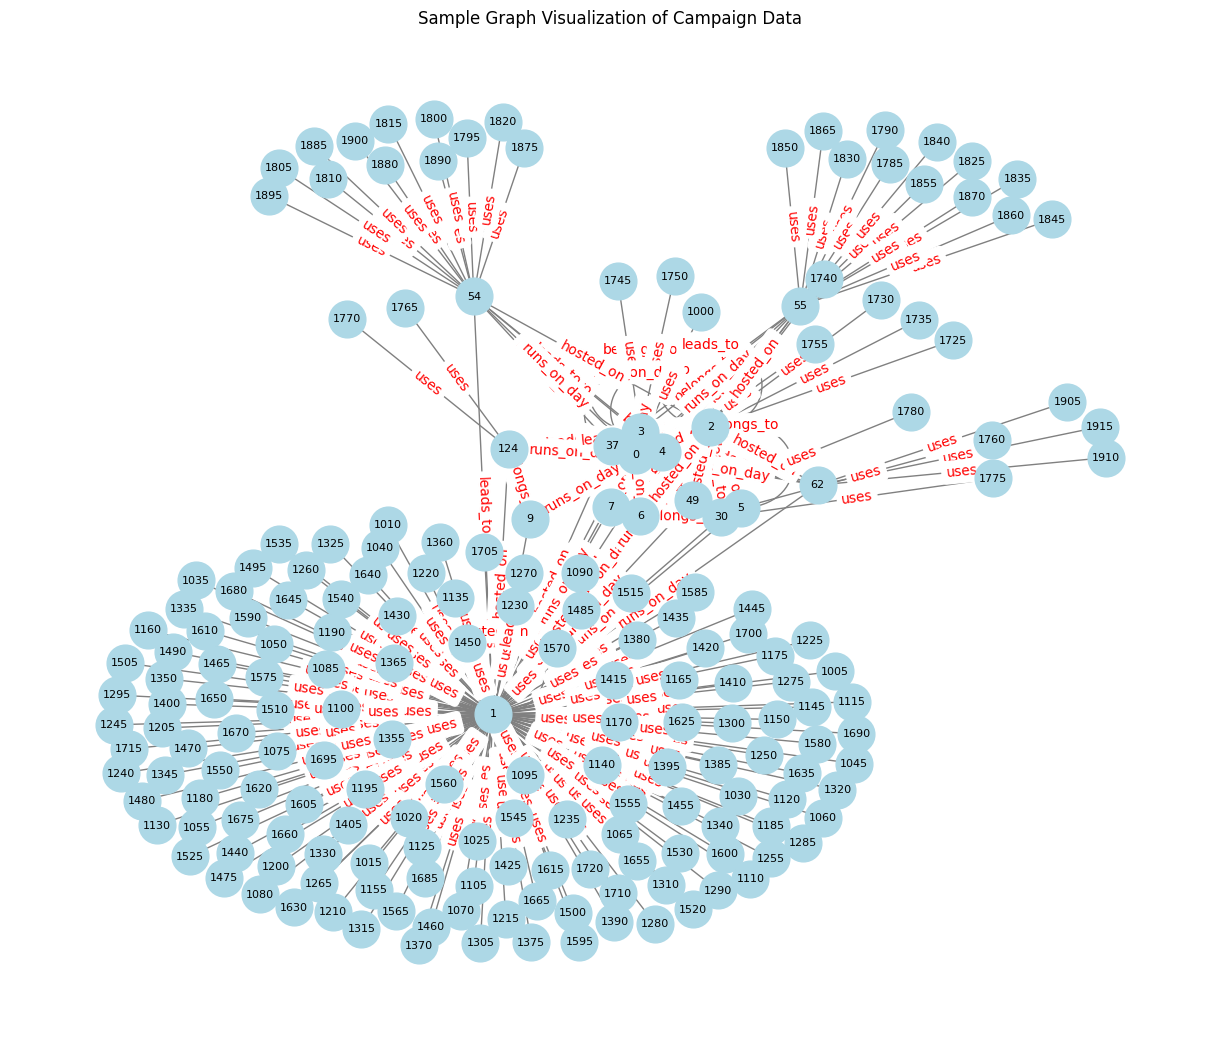

In [21]:
# Visualize the graph (showing a sample subgraph for clarity)
subgraph = G.subgraph(list(G.nodes)[:200])  # Limit visualization to 20 nodes for simplicity
pos = nx.spring_layout(subgraph, seed=42)  # Consistent layout for repeated plots
plt.figure(figsize=(12, 10))
nx.draw(subgraph, pos, with_labels=True, node_size=700, node_color="lightblue", font_size=8, font_color="black", edge_color="gray")
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels={(u, v): d['relationship'] for u, v, d in subgraph.edges(data=True)}, font_color="red")
plt.title("Sample Graph Visualization of Campaign Data")
plt.show()

In [19]:
data[data["campaign_item_id"] == 7].value_counts()

campaign_item_id  advertiser_id  ext_service_name  creative_id  search_tags  template_id  channel_name  campaign_budget_usd  media_cost_usd  impressions  clicks  time        weekday_cat  landing_page                                                          creative_dimension
7                 11             0                 3045         3            90.0         1             1228.652169          26.982567       3187         252     2022-10-31  0            https://www.abcjewelry.com/collections/pendant-necklaces-for-women    75000.0               1
                  12             1                 2995         1            90.0         4             1228.652169          4.005297        822          20      2022-10-28  0            https://www.abcjewelry.com/collections/pendant-necklaces-for-women    75000.0               1
                                 0                 3020         0            90.0         1             1228.652169          4.134679        960          18      

In [20]:
from node2vec import Node2Vec

# Initialize Node2Vec model
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)

# Fit the model and generate embeddings
model = node2vec.fit()

# Retrieve embeddings for each ad node
ad_embeddings = {node: model.wv[node] for node in G.nodes()}

Computing transition probabilities:   0%|          | 0/2685 [00:00<?, ?it/s]

In [24]:
campaign_embeddings = {node: model.wv[node] for node, attrs in G.nodes(data=True) if attrs['entity'] == 'campaign'}


In [25]:
X = [embedding for node, embedding in campaign_embeddings.items()]
y = [G.nodes[node]['clicks'] for node in campaign_embeddings.keys()]


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Make predictions
y_pred = regressor.predict(X_test)

# Evaluate
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))


Mean Squared Error: 2383700.924569648
R² Score: -2072.64794921875


In [29]:
print(G.nodes[campaign_id])


{'entity': 'creative', 'dimension': 75000.0}


In [28]:
# Retrieve campaign ID
campaign_id = "12345"  # Replace with the actual campaign ID

# Get Node2Vec embedding for the campaign
campaign_embedding = model.wv[str(campaign_id)]  # Node2Vec requires string keys

# Retrieve additional campaign features from the graph
campaign_features = [G.nodes[campaign_id]['impressions']]

# Combine embedding with other features
full_features = list(campaign_embedding) + campaign_features

# Predict using the regression model
predicted_clicks = regressor.predict([full_features])
print(f"Predicted Clicks for Campaign {campaign_id}: {predicted_clicks[0]}")


KeyError: 'impressions'